In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles

from sklearn.metrics import (
    confusion_matrix
    , classification_report
    , ConfusionMatrixDisplay
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
from tqdm import tqdm

In [20]:
# MacoOS device agnostic code:

if torch.cuda.is_available():
    device = "cuda" # Use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # Use Apple Silicon GPU (if available)
else:
    device = "cpu" # Default to CPU if no GPU is available
    
device

'mps'

In [5]:
# 1. Create the dataset (similar to Playground's "circle" dataset)
X, y = make_circles(
    n_samples=5000
    , factor=0.5
    , noise=0.0, random_state=27
)
y = y.reshape(-1, 1)  # Reshape y to be a column vector

X.shape, y.shape

((5000, 2), (5000, 1))

In [7]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8
    , random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 2), (4000, 2), (1000, 1), (4000, 1))

In [8]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [10]:
# 2. Define the PyTorch model
class CircleModel(nn.Module):
    def __init__(self):
        super(CircleModel, self).__init__()
        self.layer_1 = nn.Linear(2, 5)  # Input: 2 features, Output: 5 features
        self.layer_2 = nn.Linear(5, 2)  # Input: 5 features, Output: 2 features
        self.out = nn.Linear(2, 1)      # Input: 2 features, Output: 1 (binary classification)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.out(x)  # No activation here because we'll use BCEWithLogitsLoss
        return x

In [21]:
device

'mps'

In [11]:
# 3. Instantiate the model, loss function, and optimizer

model = CircleModel()

criterion = nn.BCEWithLogitsLoss()  # Combines Sigmoid + Binary Cross Entropy

optimizer = optim.SGD(
    model.parameters()
    , lr=0.1)  # Learning rate 0.1

In [12]:
# 4. Training loop

batch_size = 10
epochs = 200

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(
        X_train, y_train)
    , batch_size=batch_size
    , shuffle=True
)

# For epoch in a range..
for epoch in range(epochs):
    
    # Call model.train()
    model.train()  # Set model to training mode
    
    for X_batch, y_batch in train_loader:
        
        # Forward pass
        y_pred = model(X_batch)
        
        # Calculate the loss
        loss = criterion(y_pred, y_batch)

        # Optimizer zero grad!
        optimizer.zero_grad()

        # Loss -> backward!
        loss.backward()
        
        # optimizer step, step, step
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/200], Loss: 0.0226
Epoch [20/200], Loss: 0.0057
Epoch [30/200], Loss: 0.0038
Epoch [40/200], Loss: 0.0035
Epoch [50/200], Loss: 0.0026
Epoch [60/200], Loss: 0.0025
Epoch [70/200], Loss: 0.0019
Epoch [80/200], Loss: 0.0016
Epoch [90/200], Loss: 0.0012
Epoch [100/200], Loss: 0.0013
Epoch [110/200], Loss: 0.0010
Epoch [120/200], Loss: 0.0013
Epoch [130/200], Loss: 0.0010
Epoch [140/200], Loss: 0.0007
Epoch [150/200], Loss: 0.0008
Epoch [160/200], Loss: 0.0009
Epoch [170/200], Loss: 0.0007
Epoch [180/200], Loss: 0.0006
Epoch [190/200], Loss: 0.0006
Epoch [200/200], Loss: 0.0006


In [13]:
# 5. Testing the model

# Set model to evaluation mode
model.eval()  
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = torch.sigmoid(y_test_pred)  # Apply sigmoid to convert logits to probabilities
    y_test_pred_class = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions

# Calculate accuracy
accuracy = (y_test_pred_class == y_test).sum().item() / y_test.size(0)
print(f"Test Accuracy: {accuracy:.6f}")

Test Accuracy: 1.000000


In [14]:
# Ensure the model is in evaluation mode
model.eval()

# Get predictions on the test set
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = torch.sigmoid(y_test_pred)  # Apply sigmoid to logits
    y_test_pred_class = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions

# Convert predictions and true labels to NumPy arrays (required by sklearn)
y_test_pred_class = y_test_pred_class.numpy()
y_test = y_test.numpy()

In [15]:
# 1. Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_class)
cm

array([[2012,    0],
       [   0, 1988]])

In [16]:
# 2. Print classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_class))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2012
         1.0       1.00      1.00      1.00      1988

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



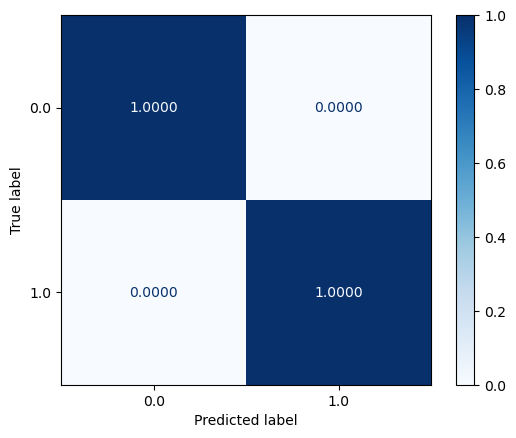

In [18]:
# 3. Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_class 
    , normalize='true', values_format='.4f', cmap='Blues'
);

In [ ]:
# Build model with non-linear activation function
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)